## Урок 6. Рекуррентные нейронные сети. LSTM. GRU.
1. Провести сравнение RNN, LSTM, GRU на датасете отзывов (из предыдущих занятий/материалов)


In [1]:
# !pip install regex
# !pip install stop_words
# !pip install pymorphy2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

from sklearn import linear_model
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.model_selection import train_test_split
from collections import defaultdict

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D, SimpleRNN, LSTM, GRU, Masking
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import TensorBoard 
from keras.objectives import categorical_crossentropy
from keras.callbacks import EarlyStopping 

In [3]:
data = pd.read_excel("отзывы за лето.xls")
data.head(2)

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14


In [4]:
exclude = set(punctuation)
sw = set(get_stop_words("ru"))
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in exclude]
    return " ".join(txt)

data['text'] = data['Content'].apply(preprocess_text)
data = data[data['Rating'] != 3]
data['target'] = (data['Rating'] > 3)*1

In [5]:
data.head(2)

,Rating,Content,Date,text,target
0,5,It just works!,2017-08-14,it just works,1
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14,в целое удобноной приложениеиз минус хотеть сл...,1


In [6]:
max_words = 3000
max_len = 40
num_classes = 1

# Training
epochs = 5
batch_size = 300
print_batch_n = 100

In [7]:
df_train, df_test = train_test_split(data,  random_state=42, test_size=0.2)
df_train, df_val  = train_test_split(df_train, random_state=42, test_size=0.2)

In [8]:
text_corpus_train = df_train['text'].values
text_corpus_valid = df_val['text'].values
text_corpus_test = df_test['text'].values

In [9]:
tokenizer = Tokenizer(num_words=None, 
                     filters='#$%&()*+-<=>@[\\]^_`{|}~\t\n',
                     lower = False, split = ' ')
tokenizer.fit_on_texts(text_corpus_train)

sequences_train = tokenizer.texts_to_sequences(text_corpus_train)
sequences_val = tokenizer.texts_to_sequences(text_corpus_valid)
sequences_test = tokenizer.texts_to_sequences(text_corpus_test)

word_count = len(tokenizer.index_word) + 1
training_length = max([len(i.split()) for i in text_corpus_train])

X_train = pad_sequences(sequences_train, maxlen=training_length)
X_test = pad_sequences(sequences_test, maxlen=training_length)
X_valid = pad_sequences(sequences_val, maxlen=training_length)

In [10]:
y_train = df_train['target'].values
y_test = df_test['target'].values
y_val = df_val['target'].values

In [11]:
rnn_model, lstm_model, gru_model = Sequential(), Sequential(), Sequential()
model_ = [rnn_model, lstm_model, gru_model]
nn = [SimpleRNN, LSTM, GRU]
# Воспользуемся возможностью объединить создание разных моделей в функцию 
# с минимумом параметров
def build_model(model, nn):
  model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
  
  model.add(Masking(mask_value=0.0))
  model.add(nn(64, recurrent_dropout=0.2))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(
      optimizer='adam', 
      loss='binary_crossentropy', 
      metrics=['AUC'])

# i = 0
# for row in model_:
#   build_model(model_[i], nn[i])
#   i += 1


## RNN

In [12]:
build_model(rnn_model, SimpleRNN)


In [13]:
early_stopping=EarlyStopping(monitor='val_loss')
tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping=EarlyStopping(monitor='val_loss')

rnn_history = rnn_model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Epoch 1/10
23/23 [==============================] - 8s 341ms/step - loss: 0.5934 - auc: 0.5326 - val_loss: 0.4968 - val_auc: 0.8542
Epoch 2/10
23/23 [==============================] - 7s 321ms/step - loss: 0.3999 - auc: 0.6915 - val_loss: 0.3155 - val_auc: 0.8955
Epoch 3/10
23/23 [==============================] - 7s 321ms/step - loss: 0.3215 - auc: 0.8341 - val_loss: 0.2690 - val_auc: 0.9093
Epoch 4/10
23/23 [==============================] - 7s 321ms/step - loss: 0.2703 - auc: 0.8944 - val_loss: 0.2352 - val_auc: 0.9358
Epoch 5/10
23/23 [==============================] - 7s 321ms/step - loss: 0.2209 - auc: 0.9355 - val_loss: 0.2130 - val_auc: 0.9522
Epoch 6/10
23/23 [==============================] - 7s 324ms/step - loss: 0.1849 - auc: 0.9561 - val_loss: 0.1998 - val_auc: 0.9625
Epoch 7/10
23/23 [==============================] - 7s 321ms/step - loss: 0.1576 - auc: 0.9677 - val_loss: 0.1823 - val_auc: 0.9657
Epoch 8/10
23/23 [==============================] - 7s 323ms/step - loss: 0.

In [14]:
rnn_score = rnn_model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
# print('\n')
# print('Test score:', score[0])
# print('Test accuracy:', score[1])

7/7 [==============================] - 0s 70ms/step - loss: 0.2726 - auc: 0.9306


## LSTM

In [15]:
build_model(lstm_model, LSTM)


In [16]:
early_stopping=EarlyStopping(monitor='val_loss')
tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping=EarlyStopping(monitor='val_loss')

lstm_history = lstm_model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Epoch 1/10
23/23 [==============================] - 19s 834ms/step - loss: 0.5230 - auc: 0.5688 - val_loss: 0.3667 - val_auc: 0.8897
Epoch 2/10
23/23 [==============================] - 19s 826ms/step - loss: 0.3322 - auc: 0.8441 - val_loss: 0.2731 - val_auc: 0.9086
Epoch 3/10
23/23 [==============================] - 19s 836ms/step - loss: 0.2618 - auc: 0.9080 - val_loss: 0.2362 - val_auc: 0.9361
Epoch 4/10
23/23 [==============================] - 19s 836ms/step - loss: 0.2065 - auc: 0.9474 - val_loss: 0.1933 - val_auc: 0.9537
Epoch 5/10
23/23 [==============================] - 19s 829ms/step - loss: 0.1591 - auc: 0.9685 - val_loss: 0.1775 - val_auc: 0.9630
Epoch 6/10
23/23 [==============================] - 19s 829ms/step - loss: 0.1244 - auc: 0.9798 - val_loss: 0.1717 - val_auc: 0.9635
Epoch 7/10
23/23 [==============================] - 19s 830ms/step - loss: 0.0992 - auc: 0.9859 - val_loss: 0.1811 - val_auc: 0.9607


In [17]:
lstm_score = lstm_model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
# print('\n')
# print('Test score:', score[0])
# print('Test accuracy:', score[1])

7/7 [==============================] - 1s 134ms/step - loss: 0.2106 - auc: 0.9459


## GRU

In [18]:
build_model(gru_model, GRU)


In [19]:
early_stopping=EarlyStopping(monitor='val_loss')  
tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping=EarlyStopping(monitor='val_loss')

gru_history = gru_model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Epoch 1/10
23/23 [==============================] - 16s 701ms/step - loss: 0.5661 - auc: 0.5555 - val_loss: 0.3701 - val_auc: 0.8915
Epoch 2/10
23/23 [==============================] - 16s 696ms/step - loss: 0.3484 - auc: 0.8257 - val_loss: 0.2880 - val_auc: 0.9113
Epoch 3/10
23/23 [==============================] - 16s 687ms/step - loss: 0.2574 - auc: 0.9156 - val_loss: 0.2371 - val_auc: 0.9273
Epoch 4/10
23/23 [==============================] - 16s 684ms/step - loss: 0.1997 - auc: 0.9489 - val_loss: 0.2077 - val_auc: 0.9469
Epoch 5/10
23/23 [==============================] - 16s 686ms/step - loss: 0.1556 - auc: 0.9690 - val_loss: 0.1944 - val_auc: 0.9574
Epoch 6/10
23/23 [==============================] - 16s 684ms/step - loss: 0.1188 - auc: 0.9814 - val_loss: 0.1978 - val_auc: 0.9596


In [20]:
gru_score = gru_model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
# print('\n')
# print('Test score:', score[0])
# print('Test accuracy:', score[1])

7/7 [==============================] - 1s 115ms/step - loss: 0.2285 - auc: 0.9415


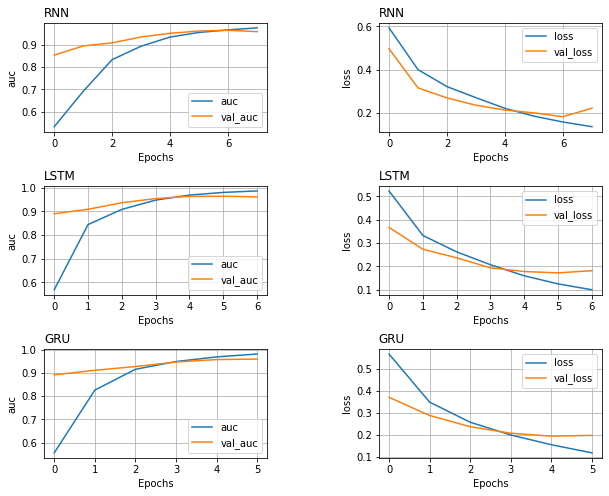

In [21]:
fig, ax = plt.subplots(nrows=3, ncols=2)
ax1, ax2, ax3, ax4, ax5, ax6 = ax.flatten()
ax_ = [ax1, ax2, ax3, ax4, ax5, ax6]
string_ = ['auc', 'loss']
history_ = [rnn_history, lstm_history, gru_history]
model_ = ['RNN', 'LSTM', 'GRU']
i = 0
def pl_plot(ax, string, history):
    ax.plot(history.history[string])
    ax.grid(True)
    ax.plot(history.history['val_'+string])
    ax.legend([string, 'val_'+string])
    ax.set_title(model_[i//2], loc='left')
    ax.set_xlabel("Epochs")
    ax.set_ylabel(string)

for row in ax_:
  pl_plot(ax_[i], string_[i%2], history_[i//2])
  # print(i%3, i//2)
  i += 1


fig.set_size_inches(10, 8)
plt.subplots_adjust(wspace=0.5, hspace=0.5)

In [35]:
print("RNN score:  {0:.4f}, RNN accuracy:  {1:.4f}".format(rnn_score[0],rnn_score[1]))
print("LSTM score: {0:.4f}, LSTM accuracy: {1:.4f}".format(lstm_score[0],lstm_score[1]))
print("GRU score:  {0:.4f}, GRU accuracy:  {1:.4f}".format(gru_score[0],gru_score[1]))

RNN score:  0.2726, RNN accuracy:  0.9306
LSTM score: 0.2106, LSTM accuracy: 0.9459
GRU score:  0.2285, GRU accuracy:  0.9415


В данном случае немного лучше оказалась модель LSTM